# Autoencoder: the Basics

An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal "noise". Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. -- from [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)

An autoencoder can be used for 

* feature analysis and dimensionality reduction
* denoising
* generating artificial contents (such as faces, musics, scenes)



![autoencoder.jpg](https://github.com/stfc-sciml/sciml-workshop/blob/master/course_3.0_with_solutions/markdown_pic/vaee.png?raw=1)


In this notebook, we will use an autoencoder in two different ways:

* **Semi-supervised**: train an autoencoder using images from one specific class in the `FashionMNIST` dataset; the trained autoencoder can then be used to decide whether an image belongs to this class based on the reconstruction error; the autoencoder can also be used to generate new images of that class by changing the *features* in the latent space (the bottleneck);

* **Unsupervised**: train an autoencoder using all images in `FashionMNIST` and cluster the images based on the features.

In [1]:
import os
import sys
import time

# helpers
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# k-means
from sklearn.cluster import KMeans
from sklearn import metrics

# widgets for dynamic controls
import ipywidgets as widgets

---

# The Dataset

We start by creating the `FashionMNIST` dataset from the torchvision datasets.

In [2]:
# Pytorch libraries
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.transforms as T

# for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# load train dataset
train_dataset = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor(), # Transform the numpy array to tensor
)

# Download test data.
test_dataset = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor(), # Transform the numpy array to tensor
)

# print info
print("Number of training samples: %d" % len(train_dataset))
print("Number of test samples: %d" % len(test_dataset))

# Create dataloader to load the dataset during training
train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# Verify dataloader is working
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}")
    break

Number of training samples: 60000
Number of test samples: 10000
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64])


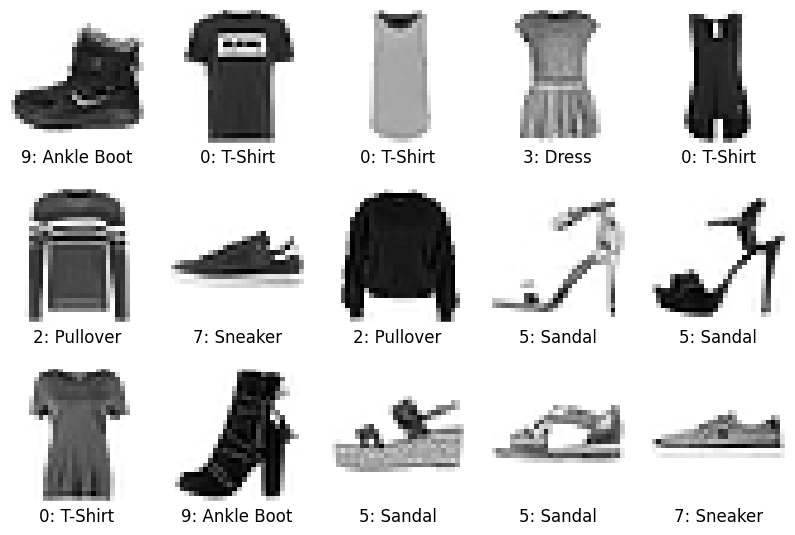

In [3]:
string_labels = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label, c='k', fontsize=12)
    plt.title(label2, c=label2_color, fontsize=12, y=-0.33)
    plt.xticks([])
    plt.yticks([])
    
ncols, nrows = 5, 3
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))

for iplot, idata in enumerate(np.random.choice(len(train_dataset), nrows * ncols)):
    img, label = train_dataset[iplot]
    label_str = "%d: %s" % (label, string_labels[label])
    subplot_image(img.squeeze(0), label_str, nrows, ncols, iplot)


---

# Semi-supervised

In this part, we will train an autoencoder using one specific class in `FashionMNIST`. The autoencoder will use the images from this class as **both the input and the output**. After training the autoencoder, we can feed in any image to decide whether it belongs to this class based on whether it can be well reconstructed by the autoencoder.

Such a strategy can be useful when 

* only one or a few classes in the dataset can be reliably labelled;
* no data in the dataset can be reliably labelled but we can generate synthetic data for some specific classes.

Besides, the autoencoder can be used to generate new images of that class by changing the **features** in the latent space (the bottleneck). 

## 1. Choose a target class

First, we choose a target class for training and extract the corresponding image subsets.

In [4]:
###############################
# choose a target class below #
###############################
# 'T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
# 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
target_class = 'Sneaker'

# get image subset of the chosen class
target_label = train_dataset.class_to_idx[target_class]

train_dataset.data = train_dataset.data[train_dataset.targets==target_label]
train_dataset.targets = train_dataset.targets[train_dataset.targets==target_label]

test_dataset.data = test_dataset.data[test_dataset.targets==target_label]
test_dataset.targets = test_dataset.targets[test_dataset.targets==target_label]

print('Number of images labelled "%s":' % (target_class,))
print('%d in training data' % (len(train_dataset)))
print('%d in test data' % (len(test_dataset)))

# instantiate new dataloder for the new dataset
train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

Number of images labelled "Sneaker":
6000 in training data
1000 in test data


## 2. Build and train the autoencoder

As shown in the opening figure, an autoencoder contains three parts:

* the encoder
* the bottleneck
* the decoder

Here we use three dense layers to implement these parts. The layers in the encoder and the decoder are reciprocal.

### Build the autoencoder

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

class AutoEncoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=8, output_dim=784, dropout=0.0):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, output_dim),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        
        x = self.encoder(x)
        
        x = self.decoder(x)
        
        return x

### Create and compile the model

In [6]:
# Create the model
model = AutoEncoder(input_dim=784)
print(model)

# Compile the model using a dummy input with batch size 1
inputs = torch.rand((8, 1, 28, 28), dtype=torch.float32)
print('Inputs:', inputs.size())
outputs = model(inputs)
print('Outputs:', outputs.size())

AutoEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=784, bias=True)
    (4): Sigmoid()
    (5): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  )
)
Inputs: torch.Size([8, 1, 28, 28])
Outputs: torch.Size([8, 1, 28, 28])


## Define loss function
The objective is to recreate the input image by minimizing the error between the reconstructed image and the input image. In PyTorch, we can use the `torch.nn.L1Loss()` function to computes the mean absolute error (MAE) between the predicted output (reconstructed data) and the ground truth (original data).  

In [7]:
loss_fn = nn.L1Loss()

### Train the autoencoder

We will modify the training scripts used in [DNN_basics.ipynb](../DNN/DNN_basics.ipynb) to adjust to our requirements. Since the decoder doesn't output the probability of the predicted class, we will simply use `error` as our metrics. The smallest the `error`, the accurate the model. 

**NOTE**: The input and output images are identical in this case.

In [8]:
# define a train function
def train(dataloader, model, loss_fn, optimizer, device):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    
    train_loss, train_error = 0, 0
    for batch, (X, y) in enumerate(dataloader):

        # place tensors to device
        X, y = X.to(device), y.to(device)

        # Forward pass 
        pred_y = model(X)

        # compute loss
        loss = loss_fn(pred_y, X)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.detach().item()
        train_error += loss.detach().item()
    
    train_loss /= num_batches
    train_error /= num_batches
    
    return train_loss, train_error

# define a test function to evaluate the model
def test(dataloader, model, loss_fn, device):
    # set the model to eval mode
    model.eval()
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_error = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # inference/prediction
            pred_y = model(X)

            # compute test loss and accuracy
            test_error += loss_fn(pred_y, X).item()
            
    test_error /= num_batches

    return test_error, test_error

def trainer(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    
    start = time.time()
    
    h = dict(train_loss=[], test_loss=[], train_error=[], test_error=[])
    
    for t in range(epochs):
        print(f"\nEpoch {t+1}/{epochs}: ", end='')
        
        train_loss, train_error = train(train_dataloader, model, loss_fn, optimizer, device)

        test_loss, test_error = test(test_dataloader, model, loss_fn, device)
        
        print(f"train_loss: {train_loss:0.3f}, train_error: {(train_error):0.3f}, test_error: {(test_error):0.3f}")


        h['train_loss'].append(train_loss)
        h['test_loss'].append(test_loss)
        h['train_error'].append(train_error)
        h['test_error'].append(test_error)

    print(f"Done in {time.time()-start:.3f}secs!")
    
    return h

epochs = 100
nfeature = 8 # latent dim

# Run the training on GPU if available 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = AutoEncoder(input_dim=784, latent_dim=nfeature).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.L1Loss()

history = trainer(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device)


Epoch 1/100: train_loss: 0.147, train_error: 0.147, test_error: 0.082

Epoch 2/100: train_loss: 0.077, train_error: 0.077, test_error: 0.072

Epoch 3/100: train_loss: 0.072, train_error: 0.072, test_error: 0.068

Epoch 4/100: train_loss: 0.068, train_error: 0.068, test_error: 0.064

Epoch 5/100: train_loss: 0.063, train_error: 0.063, test_error: 0.061

Epoch 6/100: train_loss: 0.060, train_error: 0.060, test_error: 0.058

Epoch 7/100: train_loss: 0.057, train_error: 0.057, test_error: 0.056

Epoch 8/100: train_loss: 0.055, train_error: 0.055, test_error: 0.054

Epoch 9/100: train_loss: 0.054, train_error: 0.054, test_error: 0.052

Epoch 10/100: train_loss: 0.052, train_error: 0.052, test_error: 0.052

Epoch 11/100: train_loss: 0.052, train_error: 0.052, test_error: 0.051

Epoch 12/100: train_loss: 0.051, train_error: 0.051, test_error: 0.051

Epoch 13/100: train_loss: 0.051, train_error: 0.051, test_error: 0.050

Epoch 14/100: train_loss: 0.050, train_error: 0.050, test_error: 0.050



## 3. Reconstruction and decision

Next, we use our autoencoder to reconstruct all the test images and decide whether they belong to the target class based on the reconstruction error. We will create another dataloader to load all image at once and pass to the model.

In [9]:
# reconstruct test images
test_dataset = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor(), # Transform the numpy array to tensor
)

test_images = test_dataset.data.numpy().astype(np.float32)
test_labels = test_dataset.targets.numpy().astype(np.float32)

with torch.no_grad():
    test_images_in = torch.from_numpy(test_images).to(device)
    test_images_reconstructed = model(test_images_in).squeeze().cpu()


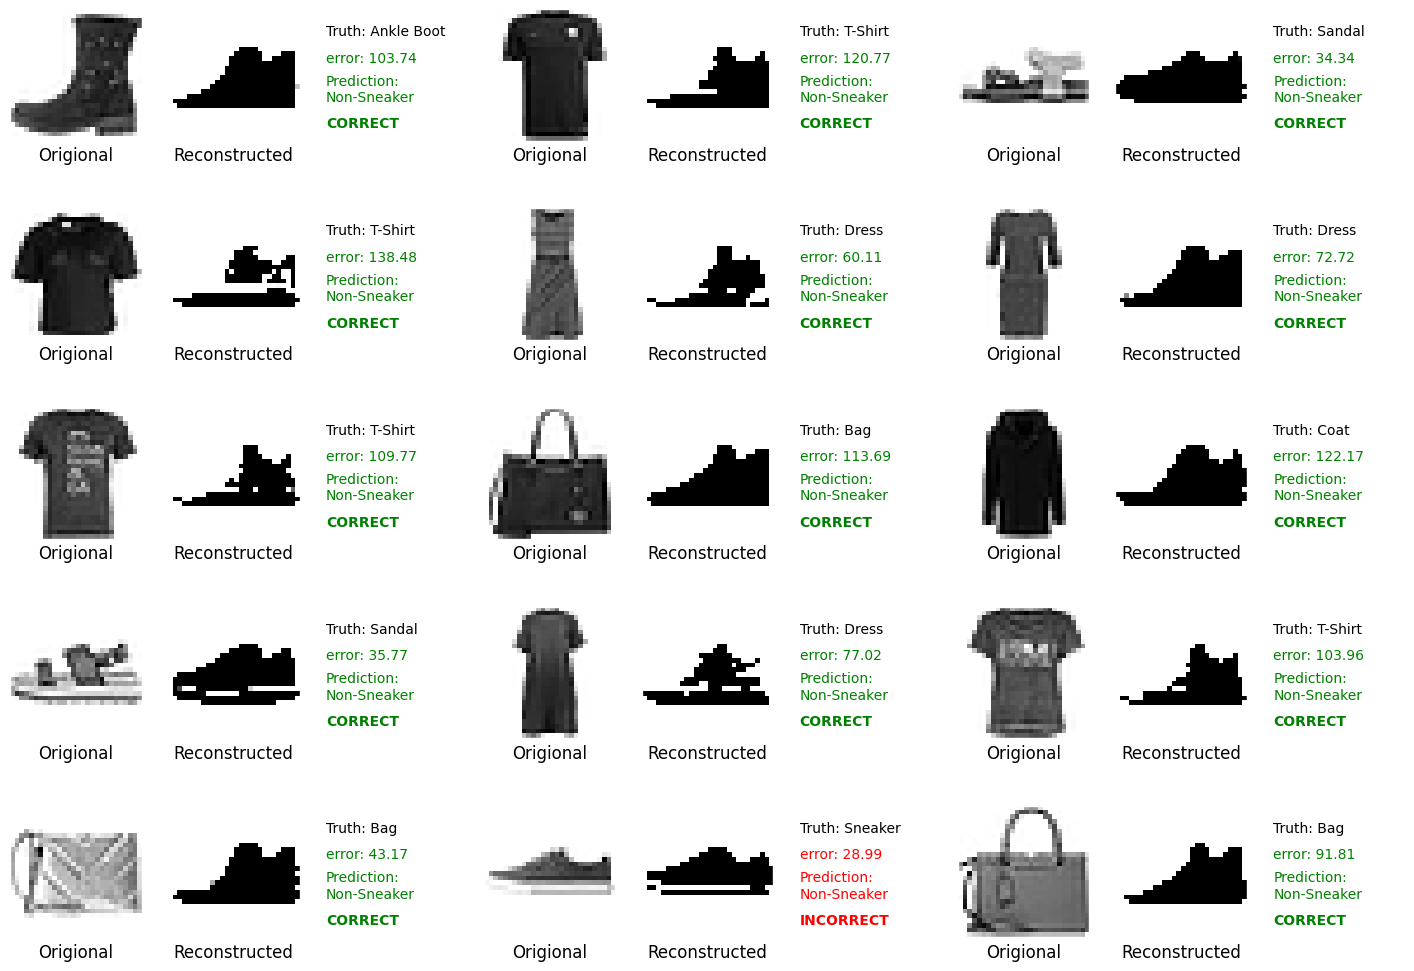

In [11]:
############################
# specify a threshold loss #
############################
# we suppose that an image should belong to the target class
# if the error is smaller than this threshold
error_threshold = 0.3

# randomly plot original and reconstructed images and decisions
nrows = 5
ncols = 3
plt.figure(dpi=100, figsize=(6 * ncols, 2.5 * nrows))
for iplot, itest in enumerate(np.random.choice(len(test_images), nrows * ncols)):
    # plot original and reconstructed images
    subplot_image(test_images[itest], 'Origional', nrows, ncols * 3, iplot * 3)
    subplot_image(test_images_reconstructed[itest], 'Reconstructed', nrows, ncols * 3, iplot * 3 + 1)
    
    # truth
    truth = (test_labels[itest] == target_label)

    # compute loss
    error = loss_fn(torch.from_numpy(test_images[itest]), test_images_reconstructed[itest])
    
    # prediction
    pred = (error < error_threshold)
    
    # correct or not?
    correct = (truth == pred)
    
    # write information
    subplot_image([[0]], '', nrows, ncols * 3, iplot * 3 + 2)
    textcolor = 'g' if correct else 'r'
    plt.text(-.5, -.3, 'Truth: %s' % string_labels[test_labels[itest].item()], c='k')
    plt.text(-.5, -.1, 'error: %.2f' % error, c=textcolor)
    plt.text(-.5, .2, 'Prediction:\n%s' % (target_class if pred else 'Non-%s' % target_class), c=textcolor)
    plt.text(-.5, .4, "CORRECT" if correct else 'INCORRECT', c=textcolor, weight='bold')
plt.show()

**NOTE**:
It is clear that the autoencoder tends to reshape every input image into the target class. This is why we can use the reconstruction error for decision.

## 4. Generate new images

We can also use the autoencoder to generate new images with the following steps:

1. encode an input image by the encoder;
2. change its features in the latent space;
3. decode the changed features to generate a new image.

### Extract encoder and decoder from autoencoder

We must first extract the encoding and decoding parts from the autoencoder.

### Encode the images

In [12]:
# get a batch of samples from dataloader
target_train_images = train_dataset.data.to(torch.float32)

with torch.no_grad():
    # encode training images 
    target_train_images_encoded = model.encoder(target_train_images.to(device)).cpu()
    
    # reconstruct training images
    target_train_images_reconstructed = model.decoder(target_train_images_encoded.to(device)).cpu()

# print the shapes
print('Shape of original: %s' % str(target_train_images.shape))
print('Shape of encoded: %s' % str(target_train_images_encoded.shape))
print('Shape of reconstructed: %s' % str(target_train_images_reconstructed.shape))

Shape of original: torch.Size([6000, 28, 28])
Shape of encoded: torch.Size([6000, 8])
Shape of reconstructed: torch.Size([6000, 1, 28, 28])


### Generate new images

In [13]:
# pick the index of the original image (0~5999)
image_index = 5999

# print original features
encoded_original = target_train_images_encoded[image_index]
print('The %d features in the latent space:' % nfeature)
print(list(encoded_original))

The 8 features in the latent space:
[tensor(332.4478), tensor(-383.6559), tensor(-869.9739), tensor(228.0299), tensor(478.7343), tensor(216.5012), tensor(235.5911), tensor(-1358.7761)]


In the following cell, we will implement a UI with slider controls so that we can dynamically change the features and see how the decoded image reacts to such changes.

In [14]:
# create sliders
sliders = []
argdict = {}
# slider range
smin = encoded_original.min() - (encoded_original.max() - encoded_original.min())
smax = encoded_original.max() + (encoded_original.max() - encoded_original.min())
for i in np.arange(nfeature):
    sliders.append(widgets.FloatSlider(min=smin, max=smax, step=.01, value=encoded_original[i], 
                                       description='Feature %d:' % (i + 1,),
                                       layout=widgets.Layout(width='auto', height='auto')))
    # associate sliders with varaibles passed to the respondent function
    argdict['v%d' % (i + 1)] = sliders[i]
ui = widgets.VBox(sliders)

# the UI-respondent function
def respond(**kwargs):
    ##### decoding happens here #####
    with torch.no_grad():
        encoded_modified = torch.from_numpy(np.array(list(kwargs.values()), dtype=np.float32)).unsqueeze(0) # input should be (bs, dim)
        decoded_modified = model.decoder(encoded_modified.to(device)).cpu().squeeze()
        
    # plot images
    plt.figure(dpi=100, figsize=(10, 3))
    subplot_image(target_train_images[image_index].squeeze(), 'Original', 1, 3, 0)
    subplot_image(target_train_images_reconstructed[image_index].squeeze(), 'Reconstructed original', 1, 3, 1)
    subplot_image(decoded_modified, 'Reconstructed modified', 1, 3, 2)
    plt.show()

# craete UI
out = widgets.interactive_output(respond, argdict)
display(ui, out)

Output()

## Exercises

* The size of the latent space, i.e., `nfeature` in the code, is the most critical network parameter. Try a smaller one (such as 4) and a larger one (such as 16) to see their influences.

* Implement the autoencoder using convolutional layers. For decoding, you can use `Conv2DTranspose` and `UpSampling2D` as the reciprocal layers of `Conv2D` and `MaxPool2D`, respectively.


---

# Unsupervised

In this part, we will use an autoencoder for unsupervised learning. We have learnt two clustering algorithms in [clustering_kmeans_GMM.ipynb](../CLASSICAL/clustering_kmeans_GMM.ipynb), k-means and the Gaussian mixture method. Clustering algorithms are challenged by a large input dimensionality, such as 28 $\times$ 28 for `FashionMNIST`. To reduce the dimensionality, we can first train an autoencoder to encode the images and conduct clustering in the latent space.

We use the same architecture as the previous one. The only difference is that we will use all the 10 classes for training. For this we will create the datasets and dataloader from begining to make sure all classes are included.  

In [15]:
# load dataset
train_dataset = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor(), # Transform the numpy array to tensor
)

# Download test data.
test_dataset = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor(), # Transform the numpy array to tensor
)

# print info
print("Number of training samples: %d" % len(train_dataset))
print("Number of test samples: %d" % len(test_dataset))

# Create dataloader to load the dataset during training
train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

Number of training samples: 60000
Number of test samples: 10000


In [16]:
epochs = 100
nfeature = 8 # latent dim

# Run the training on GPU if available 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = AutoEncoder(latent_dim=nfeature)
model = model.to(device)

# create a optimizer with constant learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_fn = nn.L1Loss()

history = trainer(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device)


Epoch 1/100: train_loss: 0.109, train_error: 0.109, test_error: 0.079

Epoch 2/100: train_loss: 0.075, train_error: 0.075, test_error: 0.073

Epoch 3/100: train_loss: 0.071, train_error: 0.071, test_error: 0.070

Epoch 4/100: train_loss: 0.069, train_error: 0.069, test_error: 0.069

Epoch 5/100: train_loss: 0.067, train_error: 0.067, test_error: 0.067

Epoch 6/100: train_loss: 0.066, train_error: 0.066, test_error: 0.066

Epoch 7/100: train_loss: 0.065, train_error: 0.065, test_error: 0.065

Epoch 8/100: train_loss: 0.064, train_error: 0.064, test_error: 0.065

Epoch 9/100: train_loss: 0.064, train_error: 0.064, test_error: 0.064

Epoch 10/100: train_loss: 0.063, train_error: 0.063, test_error: 0.064

Epoch 11/100: train_loss: 0.063, train_error: 0.063, test_error: 0.064

Epoch 12/100: train_loss: 0.063, train_error: 0.063, test_error: 0.063

Epoch 13/100: train_loss: 0.062, train_error: 0.062, test_error: 0.063

Epoch 14/100: train_loss: 0.062, train_error: 0.062, test_error: 0.063



## 2. Encode the images

Extract the encoder from the autoencoder and use it to encode the images

In [ ]:
# encode images
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
with torch.no_grad():
    train_images_tensors = torch.from_numpy(train_images).to(device).to(torch.float32)
    train_images_encoded = model.encoder(train_images_tensors).cpu().numpy()
print('\n* Shape of the encoded images: %s' % str(train_images_encoded.shape))

## 3. Cluster the encoded  images

Now we can use k-means to cluster the encoded images. Note that the number of clusters does not have to be the number of the original classes (10). Here we will use 20 to relax the constraints for k-means.

In [ ]:
# build k-means
n_clusters = 20
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=500)

# train and predict
kmeans_labels = kmeans_model.fit_predict(train_images_encoded)

# print scores
print('Homogeneity score = %.3f' % metrics.homogeneity_score(train_labels, kmeans_labels))
print('Completeness score = %.3f' % metrics.completeness_score(train_labels, kmeans_labels))
print('V-measure score = %.3f' % metrics.v_measure_score(train_labels, kmeans_labels))

Further, we can plot a few images in each cluster to get a sense of the quality of clustering:

* It is shown that some similar-looking classes such as "T-shirts", "Shirts", "Coats" and "Pullovers" are not well resolved, which implies that we may need a larger latent space in the autoencoder. 

* Also, it is interesting that some classes are clustered into sub-classes, such as "Bags" into the ones with and without handles and the clothes into dark- and light-coloured ones; this explains why we need more than 10 clusters for k-means.

In [ ]:
n_image_per_cluster = 15
for cluster_label in np.arange(n_clusters):
    # get indices of the first n_image_per_cluster in this cluster
    itrains = np.where(kmeans_labels == cluster_label)[0][0:n_image_per_cluster]
    print('\n\nImages in Cluster %d:' % cluster_label)
    fig = plt.figure(dpi=100, figsize=(n_image_per_cluster * 2, n_clusters * 2))
    for iplot, itrain in enumerate(itrains):
        subplot_image(train_images[itrain], string_labels[train_labels[itrain]], 
                      n_clusters, n_image_per_cluster, iplot)
    plt.show()

### Visualise clustering in the latent space

Finally, we can visualise the clustering results in the latent space. These plots can manifest which features in the latent space are dominating the formation of certain clusters. 

In [ ]:
# specify total number of data points to show
show_ndata = 200

# specify the clusters to show
# showing all 20 clusters will make the figures unreadable; just select a few
show_clusters = np.array([1, 2, 3])

# find the data subset
show_data_indices = np.where(np.isin(kmeans_labels, show_clusters))[0][0:show_ndata]

# normalise features to [0, 1]
train_images_encoded_norm = (train_images_encoded - train_images_encoded.min()) / \
                            (train_images_encoded.max() - train_images_encoded.min())
# for better visualisation
train_images_encoded_norm = np.power(train_images_encoded_norm, .5)

# plot
plt.figure(dpi=100, figsize=(15, 15))
iplot = 0
for feature_x in np.arange(nfeature):
    for feature_y in np.arange(nfeature):
        plt.subplot(nfeature, nfeature, iplot + 1)
        x = train_images_encoded_norm[show_data_indices, feature_x]
        y = train_images_encoded_norm[show_data_indices, feature_y]
        plt.scatter(x, y, c=kmeans_labels[show_data_indices], s=10, cmap=plt.cm.Paired)
        plt.xticks([])
        plt.yticks([])
        iplot += 1
        if feature_y == 0:
            plt.ylabel('Feature %d' % feature_x, c='k')
        if feature_x == 0:
            plt.gca().xaxis.set_label_position('top') 
            plt.xlabel('Feature %d' % feature_y, c='k')
plt.tight_layout()
plt.show()

---

## Exercises

Try to increase the quality of clustering by using
1. a larger latent space in the autoencoder
2. convolutional layers for encoding and decoding
3. GMM for clustering the encodings